In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For data splitting
from sklearn.model_selection import train_test_split
# For standardization
from sklearn.preprocessing import StandardScaler

# For visualization
from matplotlib.colors import ListedColormap

# For classification
from sklearn.linear_model import LogisticRegression

In [84]:
# Read the online wine data set with no headers
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

# Assign column labels
# The feature names can be found online.
df_wine.columns = ['Class label', 
              'Alcohol', 
              'Malic acid', 
              'Ash', 
              'Alcalinity of ash', 
              'Magnesium', 
              'Total phenols', 
              'Flavanoids', 
              'Nonflavanoid phenols', 
              'Proanthocyanins', 
              'Color intensity', 
              'Hue', 
              'OD280/OD315 of diluted wines', 
              'Proline']

# Split the data set into a training set and a test set
y = df_wine.iloc[:, 0].values
X = df_wine.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
# test_size=0.3: the testing set contains 30% data
# stratify=y: both the train and testing sets have the same class proportions as the original dataset.

# Standardization
# Create a scaler
stdsc = StandardScaler()
# Fit and transform the training set
X_train_std = stdsc.fit_transform(X_train)
# Transform the testing set with the same scaler
X_test_std = stdsc.transform(X_test)

In [85]:
# Calculate the mean feature vector for each class
mean_vecs = []
for label in range(1,4): # Three classes
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(f'MV {label}: {mean_vecs[label-1]}\n')
# Without axis=0, np.mean would calculate the mean of all entries, rather than columnwise means.

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



In [86]:
# Calculate the within-class scatter matrix
# Number of features
d = X_train_std.shape[1]
# Number of classes
c = np.unique(y).shape[0]

# Initialize the scatter matrix
S_W = np.zeros((d,d))

# Calculate the scatter matrix
# Iterate for each class
for label, mv in zip(range(1,4), mean_vecs):
    # Initialize the scatter matrix for the current class
    class_scatter = np.zeros((d,d))
    # Change mv into a column vector
    mv_col = mv.reshape(d,1)
    for row in X_train_std[y_train==label]:
        # Change each row into a column vector
        example = row.reshape(d,1)
        difference = example-mv_col
        class_scatter += np.matmul(difference, difference.T)
    S_W += class_scatter
    
#print(f"Within-class scatter matrix:\n", S_W)
#print("Shape: ", S_W.shape)
#print(S_W)

In [87]:
# Number of observations in each class
# This returns the number of occurrences of nonnegative integers.
# It always counts from 0, even if 0 does not appear in the array
print(np.bincount(y_train))
# The class labels are 1,2,3. Thus we do not need the first entry
print("Number of observations in each class:",  np.bincount(y_train)[1:])

num_examples_all = np.bincount(y_train)[1:]

[ 0 41 50 33]
Number of observations in each class: [41 50 33]


In [95]:
# Use numpy covariance to find S_W
# Initialize the scatter matrix
S_W = np.zeros((d,d))
# Number of examples in each class
num_examples_all = np.bincount(y)[1:]
for label, num_examples in zip(range(1,4), num_examples_all):
    # The input of np.cov requires that each column represents a single observation
    # Therefore, we need to transpose the data matrix
    # class_scatter = np.cov(X_train_std[y_train==label].T) * (num_examples-1)
    # The default way to calculate covariance by np.cov is to devide num_examples-1, to get an unbiased result
    class_scatter = np.cov(X_train_std[y_train==label].T) * (num_examples-1)
    S_W += class_scatter

#print("Shape: ", S_W.shape)
#print(S_W)

# ???????????? Result is not the same


In [96]:
# between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)

# Initialization of the scatter matrix
S_B = np.zeros((d,d))

for mean_vec, num_examples in zip(mean_vecs, num_examples_all):
    difference = (mean_vec - mean_overall).reshape(d, 1)
    S_B += num_examples * np.matmul(difference, difference.T)

In [97]:
# Solve the eigenvalue problem
S_W_inv_S_B = np.matmul(np.linalg.inv(S_W), S_B)
eigen_vals, eigen_vecs = np.linalg.eig(S_W_inv_S_B)
# eigen_vals: 1D array, all evals
# eigen_vecs: each column is an eigenvector.
eigen_vals = eigen_vals.real

In [98]:
# Sort the eigen values for transformation
# Make a list of (eval, evect) tuples
eigen_pairs = [(eigen_vals[i], eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Sort the eigen pairs from high to low
eigen_pairs.sort(key = lambda k: k[0], reverse=True)
# key: this input is a function. We sort the list according to the output of this function, not the original entries.

In [99]:
for eigen_pair in eigen_pairs:
    print(eigen_pair[0])

8.28912191100274
4.181312494763254
6.253598975691167e-16
3.476715962081882e-16
3.476715962081882e-16
1.9994161434894455e-16
1.9994161434894455e-16
0.0
-3.5215651776847543e-17
-3.5215651776847543e-17
-3.6469671198012595e-17
-1.6753150132140388e-16
-9.131952695079934e-16


In [100]:
# Construct the transformation matrix W
# It has two columns corresponding to the first eigenvectors in the sorted list
W = np.hstack((-eigen_pairs[0][1][:,np.newaxis].real, -eigen_pairs[1][1][:,np.newaxis].real))

In [101]:
# Transform the data
X_train_lda = np.matmul(X_train_std, W)

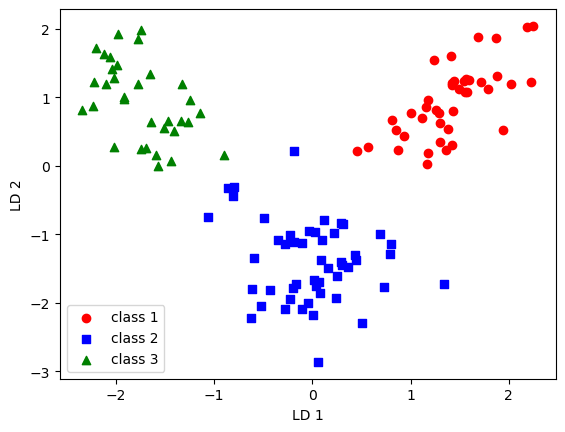

In [102]:
# Visualize the transformed data
fig = plt.figure()
ax = fig.add_subplot(111)

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    ax.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], color=c, marker=m, label=f"class {l}")
    
ax.set_xlabel("LD 1")
ax.set_ylabel("LD 2")
ax.legend()

Below, we calculate the covariance in two ways. One is to use np.cov, the other is manual implementation. The purpose is to show that the default way to calculate covariance by np.cov is to divide the sum by (number of examples - 1)

In [62]:
A = X_train_std[y_train==1]

In [63]:
np.cov(A.T)

array([[ 0.2886114 , -0.04640649, -0.12520034, -0.1923702 ,  0.01008807,
         0.10303129,  0.0818283 ,  0.00433466,  0.09342332,  0.08616157,
         0.07447061,  0.01391636,  0.10722041],
       [-0.04640649,  0.24342676, -0.05554105,  0.03861215, -0.05356088,
        -0.03321305, -0.03945115,  0.00646782, -0.03080227, -0.08844128,
        -0.10393479,  0.02713746, -0.11921615],
       [-0.12520034, -0.05554105,  0.75108486,  0.42700013,  0.29474384,
         0.01028486, -0.01092715,  0.26116136, -0.13366602, -0.0769627 ,
         0.09946116, -0.03533046, -0.03539828],
       [-0.1923702 ,  0.03861215,  0.42700013,  0.64705745,  0.23876323,
        -0.148541  , -0.12696805,  0.13378237, -0.17326713, -0.1330574 ,
         0.01277134, -0.03973881, -0.12431712],
       [ 0.01008807, -0.05356088,  0.29474384,  0.23876323,  0.5368417 ,
         0.11151347,  0.01077588,  0.17437099, -0.09408034,  0.06043918,
         0.01816557,  0.03967391, -0.07562279],
       [ 0.10303129, -0.033213

In [64]:
mean_A = np.mean(A, axis=0)
mean_A

array([ 0.9065826 , -0.34973457,  0.32010329, -0.71891449,  0.50558678,
        0.88069702,  0.95894709, -0.55161049,  0.54159322,  0.23383109,
        0.58971299,  0.65631399,  1.20749382])

In [75]:
cov_A = 0 
for x in A:
    deviation = (x - mean_A).reshape(d,1)
    cov_A += np.matmul(deviation, deviation.T)
cov_A /= (A.shape[0]-1)

In [76]:
cov_A

array([[ 0.2886114 , -0.04640649, -0.12520034, -0.1923702 ,  0.01008807,
         0.10303129,  0.0818283 ,  0.00433466,  0.09342332,  0.08616157,
         0.07447061,  0.01391636,  0.10722041],
       [-0.04640649,  0.24342676, -0.05554105,  0.03861215, -0.05356088,
        -0.03321305, -0.03945115,  0.00646782, -0.03080227, -0.08844128,
        -0.10393479,  0.02713746, -0.11921615],
       [-0.12520034, -0.05554105,  0.75108486,  0.42700013,  0.29474384,
         0.01028486, -0.01092715,  0.26116136, -0.13366602, -0.0769627 ,
         0.09946116, -0.03533046, -0.03539828],
       [-0.1923702 ,  0.03861215,  0.42700013,  0.64705745,  0.23876323,
        -0.148541  , -0.12696805,  0.13378237, -0.17326713, -0.1330574 ,
         0.01277134, -0.03973881, -0.12431712],
       [ 0.01008807, -0.05356088,  0.29474384,  0.23876323,  0.5368417 ,
         0.11151347,  0.01077588,  0.17437099, -0.09408034,  0.06043918,
         0.01816557,  0.03967391, -0.07562279],
       [ 0.10303129, -0.033213